<a href="https://colab.research.google.com/github/peterakdemir1/cs301/blob/main/Electromyography_and_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Background and Documentation

Gradient Boosting is an ensembling method which can be used in both regression and classification problems. This is a powerful technique which has several important factors, such as the loss function, a number of models/predictors called *weak learners*, and a weight updating function. 

In a regression setting, the loss function can be MSE and in classification problems the loss function can be Logarithmic Loss, and their respective equations are as follows:

MSE: L = 1/m * Σ(yi - ŷi)^2, i = 1...m

Log Loss: L = -1/m Σ(yi\*log2(ŷi) + (1-yi)\*log2(1-ŷi)), i = 1...m

As seen in other ensembling methods, there are a weak learners which are used in the final model in gradient boosting. Each weak learner is a predictor, such as a decision tree, regression tree, etc. All of the weak learners are used in conjunction with each other to create a committee, which makes the final prediction. The weak learners' predictions tend to be more inaccurate than others, and each learner ranges in significance; the more accurate a model's predictions are the more significant it is (lower loss), and vice versa (higher loss). Gradient boosting is a model that is sequential in nature - this means each weak learner uses the loss of the previous learners to create a model that shifts the overall predictions closer to the ground truth. The process starts with a simple weak predictor whose loss is calculated, then used in a weight updating function, like (Stochastic) Gradient Descent, to create another model that brings the overall predictions closer to the ground truth. Since the gradient must be calculated in Gradient Boosting, the loss function must be differentiable. Models with lower loss will contribute more than models with higher loss to the committee, or final predictor. This process is repeated for all of the weak leaners to be used, which are summed up to create the committee:

Committee Model: F(m) = f(0) + Σf(i), i = 1...m

In the above function, little f represents a weak learner, m represents the number of weak learners being used, and big F represents the committee model. As shown in the equation, the committee is represented as a composite function which is the sum of all of the weak learners.

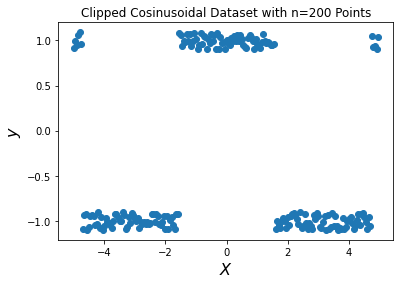

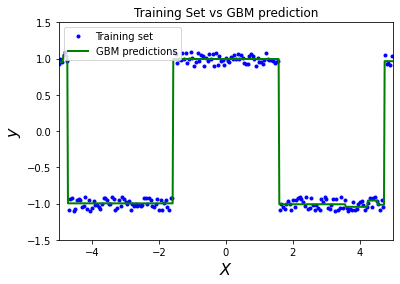

In [ ]:
####### Part 2 - Using GBM on Noisy Clipped Cosinusoidal Dataset #######
# NOTE: I used the scikit-learn models instead of building the GBM from scratch #

# Create the noisy clipped cosinusoidal dataset

from sklearn import *
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

def noise(data):
  for i in range(len(data)):
    r = random.randint(0,100)
    if r%2:
      data[i] -= random.uniform(0,0.1)
      continue
    data[i] += random.uniform(0,0.1)
  return data

x = np.arange(-5,5,1/20)
y = np.cos(x)
ys = np.sign(y)
y = noise(ys)
X = x.reshape(-1,1)
plt.scatter(x, y)
plt.title("Clipped Cosinusoidal Dataset with n=200 Points")
plt.ylabel("$y$", fontsize=16)
plt.xlabel("$X$", fontsize=16)
plt.show()

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = 0
    for regressor in regressors:
      y_pred += regressor.predict(x1.reshape(-1,1))
    # y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    plt.ylabel("$y$", fontsize=16)
    plt.xlabel("$X$", fontsize=16)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gbrt.fit(X, y)
plot_predictions(
    [gbrt], X, y, axes=[-5, 5, -1.5, 1.5], label="GBM predictions", style="g-", data_label="Training set"
)
plt.legend(loc='upper left')
plt.title("Training Set vs GBM prediction")
plt.show()

In [ ]:
####### Part 3 - Applying GBM Model to EMG Dataset #######

M = 100 # no of learners
lr = 0.001 # learning rate
# loss = 'log_loss' # loss function; sklearn GBM uses log_loss by default
classes = ['elbowing','frontkicking','hamering','headering','kneeing','pulling','punching','pushing','sidekicking','slapping', 'bowing','clapping','handshaking','hugging','jumping','running','seating','standing','walking','waving']
data = {}

# DATA PREPROCESSING #
# Only 1 of the 4 subjects' data from the dataset will be used to save time
for path, subdirs, files in os.walk('sub1/'):
    #print(files)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'Aggressive' or dirname == 'Normal':
      for i, file in enumerate(sorted(os.listdir(path))):
        D = []
        Data = open(path+'/'+file)
        for z in Data:
          splitData = z.split('\t')
          for j, number in enumerate(splitData):
            if number[-1] == '\n':
              splitData[j] = int(number[0:len(number)-1])
              continue
            splitData[j] = int(number)
          D.append(splitData)
        D = np.array(D)
        if dirname == 'Normal':
          data[classes[i+10]] = D
          continue
        data[classes[i]] = D

# total number of usable data points = 197058

# PUTTING DATA INTO RESPECTIVE X AND Y VARIABLES #
y = []
X = []
t = 1 # t variable used so 1 in every n_max data points will be used in the dataset - this shrinks the set so it runs faster
n_max = 10 # n_max variable is used to divide the dataset into (its size / n_max) - this shrinks the set so it runs faster
for x in data:
  X.append(data[x])
  for i, j in enumerate(data[x]):
    if t != n_max:
      t += 1
      continue
    y.append(x)
    t = 1
xs = np.zeros((197058//n_max,8)) # dividing dataset into original size / n_max
tot = 0 # variable used to maintain index of x dataset
t = 1
for i in X:
  for j in i:
    if t != n_max:
      t += 1
      continue
    xs[tot] = j
    tot += 1
    t = 1
y = np.array(y)
X = xs
X = np.array(X)
# END OF PREPROCESSING #

# DATA SPLITTING #
frac_of_dataset = 1 # This is used to further split the dataset into a smaller, more manageable size
train_size = int(X.shape[0]*0.7*frac_of_dataset) # 70% of dataset is for training
test_size = int(X.shape[0]*frac_of_dataset) # 30% of dataset is for testing
# these next 4 lines shuffle the dataset (X and y in unison) so when it is split into train and test, 
# both sets will contain all classes, rather than most classes appearing in the train and a few in the test.
randomize = np.arange(X.shape[0])
np.random.shuffle(randomize)
x = X[randomize]
y = y[randomize]
X_train, X_test = X[:train_size], X[train_size:test_size] 
y_train, y_test = y[:train_size], y[train_size:test_size]
# END OF SPLITTING #

# Gradient Boosting Classification and Results
gbc = GradientBoostingClassifier(n_estimators = M, learning_rate=lr, max_depth=2, random_state=0)
classifier = gbc.fit(X_train, y_train)
print("Number of Data Points Used =", X.shape[0])
print("GBM Prediction Accuracy =",classifier.score(X_test, y_test))

Number of Data Points Used = 19705
GBM Prediction Accuracy = 0.05074424898511502
